# Brain Tumour Classification From MRI

##### Objective

The objective of this investigation is to train a model to classify, using a T1-weighted, contrast enhanced, MRI images of a patient's brain, if the patient has meningioma, glioma, pituitary tumour, or is cancer-free. As this is an investigative approach, two models will be trained and will be compared to each other in order to understand the effects of the convolutional layer on image classification problems.

##### About The Data

The data used in this exploration comes from a combination of three different datasets of T1-weighted contrast-enhanced MRI images. The first dataset is from Jun Cheng, and was acquired at Nanfang Hospital, Guangzhou, China and General Hospital, Tianjin Medical University, China between the years 2005 to 2010. It contains a total of 3064 images, of those 708 for meningioma, 1426 of glioma, and 930 of pituitary tumour. The second dataset was collected by Navoneel Chakrabarty and Swati Kanchan and uploaded to Kaggle by Sartaj Bhuvaji, Ankita Kadam, Prajakta Bhumkar, Sameer Dedge, and Swati Kanchan. It contains 100 images of glioma, 115 of meningioma, 74 of pituitary tumour, and 105 of cancer-free MRIs. The third is the Br35H Brain Tumour dataset, with 3000 MRI images, collected by Ahmed Hamada. The complete dataset was combined by Masoud Nickparvar, containing 7023 images, separated into the 4 classes mentioned previously.

The images are all in different sizes due to the different sources, which will have to be dealt with during preprocessing.



##### Data Preprocessing

In [23]:
# ------------------ Data ------------------ #
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import collections
import numpy as np
# ------------------ TensorFlow and Keras ------------------ #
import tensorflow as tf
import tensorflow.keras as keras
from keras import preprocessing, Sequential
from visualkeras import layered_view
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ------------------ Warnings ------------------ #
import warnings
warnings.filterwarnings("ignore")

Functions for Preprocessing

In [24]:
# load images with 224, 224 size (important as some are in different sizes)
def load_image_dataset(directory, image_size=(224, 224), batch_size=32):
    dataset = preprocessing.image_dataset_from_directory(
        directory,
        seed=123,               
        image_size=image_size,  
        batch_size=batch_size
    )
    return dataset

def create_class_distribution_plot(dataset, dataset_name):
    # count images per class
    class_names = dataset.class_names
    all_labels = []

    for _, labels in dataset:
        all_labels.extend(labels.numpy())

    # count
    class_counts = dict(collections.Counter(all_labels))

    # create pandas df
    df = pd.DataFrame({
        "Class": [class_names[k] for k in class_counts.keys()],
        "Count": list(class_counts.values())
    })

    plt.figure(figsize=(15,7))
    ax = sns.barplot(x="Count", y="Class", data=df, palette="viridis")

    plt.xlabel("Number of Samples", fontsize=12)
    plt.ylabel("Class", fontsize=12)
    plt.title(f"Count of Images in Each Class - {dataset_name}", fontsize=20)
    ax.bar_label(ax.containers[0])
    plt.tight_layout()
    plt.show()

In [25]:
# Download latest version of df
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

In [26]:
training_path = path + "/Training"
testing_path = path + "/Testing"

In [27]:
train_dataset = load_image_dataset(training_path)
test_dataset = load_image_dataset(testing_path)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


Check Class Distributions

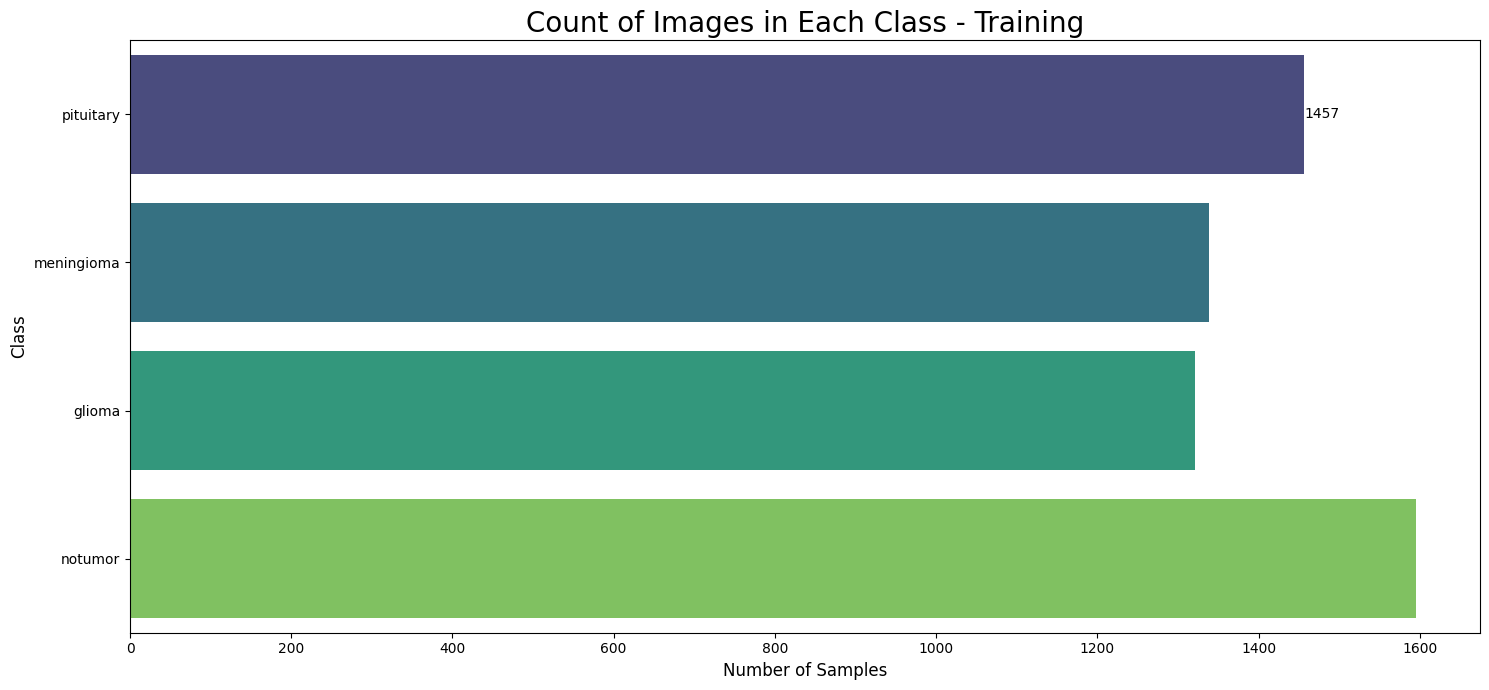

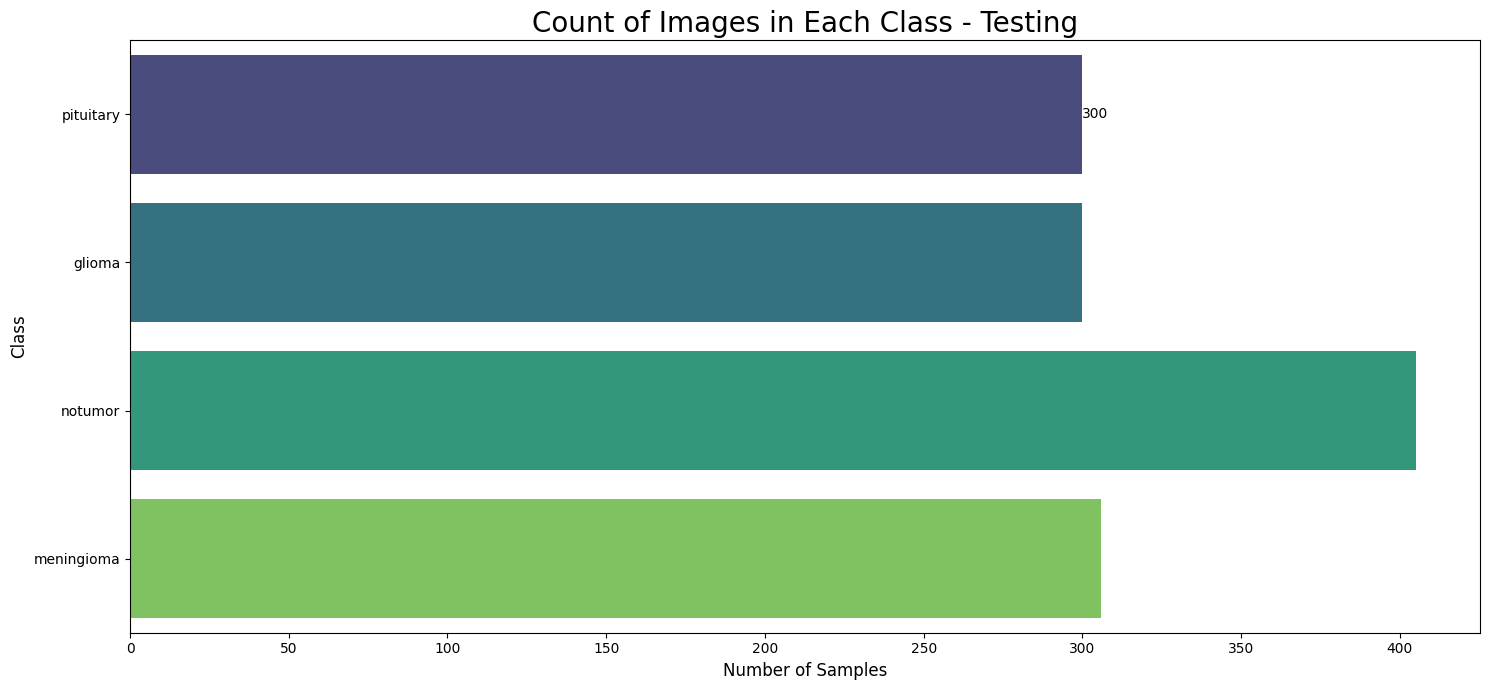

In [28]:
create_class_distribution_plot(train_dataset, "Training")
create_class_distribution_plot(test_dataset, "Testing")

Data Augmentation and Normalisation

In [29]:
# create data augmentation process
data_augmentation = Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
])

# returns 0 to 1
def normalise_images(images):
    return images / 255.0

# normalise train
train_dataset_n = train_dataset.map(
    lambda x, y: (normalise_images(x), y)
)

# normalise test
test_dataset_n = test_dataset.map(
    lambda x, y: (normalise_images(x), y)
)

# apply augmentation to train
train_dataset_n_a = train_dataset_n.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

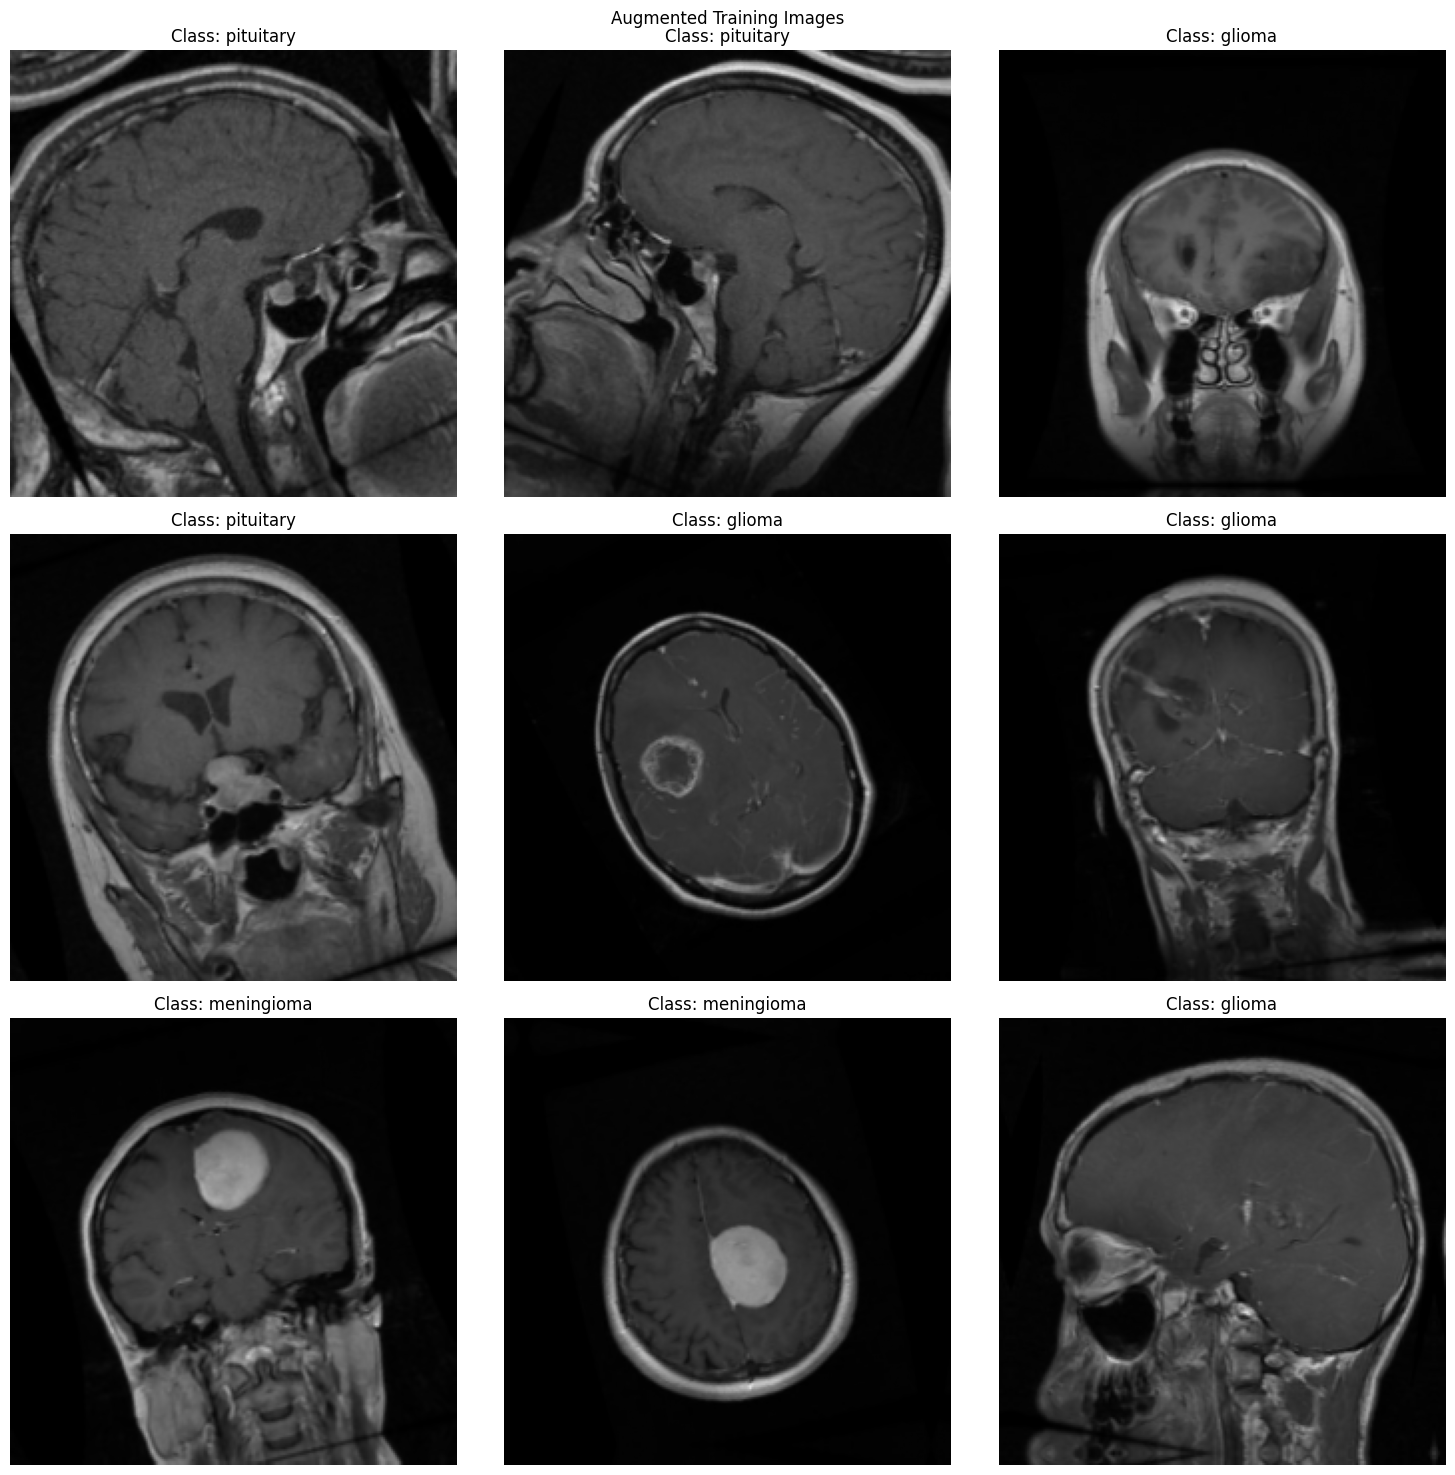

In [30]:
# plot 9 images from augmented training with label
plt.figure(figsize=(15, 15))
for images, labels in train_dataset_n_a.take(1):
    for i in range(9):
        plt.subplot(3, 3, i+1)  
        plt.imshow(images[i])
        
        # get class name
        class_name = train_dataset.class_names[labels[i].numpy()]
        
        # title
        plt.title(f"Class: {class_name}")
        plt.axis('off')

plt.suptitle('Augmented Training Images')
plt.tight_layout()
plt.show()

# performance optimization
train_dataset_final = train_dataset_n_a.cache().prefetch(tf.data.AUTOTUNE)
test_dataset_final = test_dataset_n.cache().prefetch(tf.data.AUTOTUNE)

In [31]:
# one-hot encode labels
train_dataset_final = train_dataset_final.map(
    lambda x, y: (x, tf.one_hot(y, depth=4))
)

test_dataset_final = test_dataset_final.map(
    lambda x, y: (x, tf.one_hot(y, depth=4))
)

##### Creating Model 1 (Dense Model)

The first model will be a neural network composed of many dense layers and no convolutional layer. It has 4 dense blocks of decreasing sizes until the final output layer with a size of 4 for the 4 classes. It has batch normalisation between each layer as well as dropout to avoid overfitting. It also has l2 regularisation in its dense layer.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_7 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │    38,535,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,645,444 (147.42 MB)

 Trainable params: 38,644,036 (147.42 MB)

 Non-trainable params: 1,408 (5.50 KB)

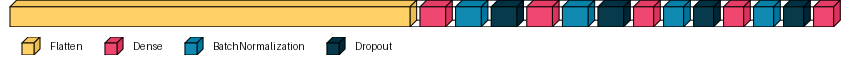

In [32]:
image_shape = (224, 224, 3)

# model 1, no convolutional layer
model1 = keras.Sequential([
    # flatten the input
    keras.layers.Flatten(input_shape=image_shape),
    
    # first block
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    # second block
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    # third block
    keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    
    # fourth block
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    
    # out block
    keras.layers.Dense(4, activation='softmax')
])

model1.summary()

# visualise the model
layered_view(model1, legend=True, max_xy=300)


##### Creating Model 2 (CNN)

The iteration of the model will be using an architecture inspired by VGG. The first block has two convolutional layers with 32 filters of 3x3 size. Then the outputs are 'maxpooled' using a (2, 2) size. Then, the number of filters are doubled and the input dimensions are now halved. This is done 4 times until the output is 14x14. Here, VGG applies another convolutional layer, but we won't as this is much more simplistic than VGG. After the convolutional layers, 2 dense layers are used, with one dropout to avoid overfitting in between them. The final dense layer uses the softmax activation function and has a size 4 for the 4 classes.

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 50176)          │             

 Total params: 26,870,820 (102.50 MB)

 Trainable params: 26,867,876 (102.49 MB)

 Non-trainable params: 2,944 (11.50 KB)

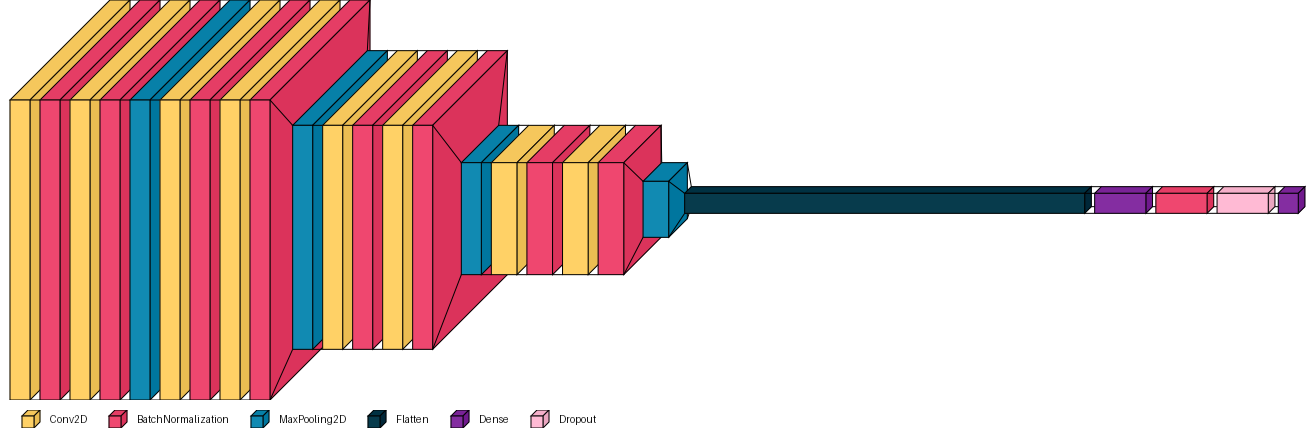

In [33]:
image_shape = (224, 224, 3)

model2 = keras.Sequential([
    # first block
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=image_shape),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    
    # second block
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    
    # third block
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    
    # fourth block
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2, 2)),
    
    # flatten and dense layer
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    # output layer (dense layer of size 4 with softmax activation)
    keras.layers.Dense(4, activation='softmax') 
])

model2.summary()

# visualise the model
layered_view(model2, legend=True, max_xy=300)


##### Compiling Models:

The models will be compiled using a slightly modified Adam optimiser.

Custom Optimiser Parameters:

- Learning rate will be affected by exponential decay to help model converge.

- Early stopping will be used in order to stop training in the case of overfitting ('patience' epochs with no improvement).

- The learning rate will be reduced (by 'factor') if on a plateau for 'patience' epochs.

In [39]:
# learning rate
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

# early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',     
    patience=5,            
    restore_best_weights=True,  
    min_delta=0.001         
)

# reduce learning rate on plateaus
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.2,             
    patience=10,             
    min_lr=0,
    min_delta=0.0001          
)


# compile model 1
model1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)


# compile model 2
model2.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


##### Train Models

In [40]:
EPOCHS = 40

history_nn = model1.fit(
    train_dataset_final,
    validation_data=test_dataset_final,
    epochs=EPOCHS,
    verbose=1,
)

history_cnn = model2.fit(
    train_dataset_final,
    validation_data=test_dataset_final,
    epochs=EPOCHS,
    verbose=1,
)

Epoch 1/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 177ms/step - accuracy: 0.6516 - loss: 1.3529 - val_accuracy: 0.5492 - val_loss: 1.4975
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.6588 - loss: 1.3049 - val_accuracy: 0.4432 - val_loss: 1.7537
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.6610 - loss: 1.2974 - val_accuracy: 0.6171 - val_loss: 1.3444
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.6569 - loss: 1.3071 - val_accuracy: 0.5919 - val_loss: 1.3936
Epoch 5/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.6504 - loss: 1.2911 - val_accuracy: 0.6270 - val_loss: 1.3593
Epoch 6/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.6521 - loss: 1.3119 - val_accuracy: 0.4798 - val_loss: 1.5617
Epoch 7/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.6550 - loss: 1.3009 - val_accuracy: 0.5126 - val_loss: 1.5771
Epoch 8/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.6563 - loss: 1

Performance Analysis

Function for Analysis

In [72]:
from sklearn.metrics import classification_report, confusion_matrix

# compare training histories
def plot_training_history(history_nn, history_cnn):
    plt.figure(figsize=(15, 10))
    
    # accuracy graph
    plt.subplot(2, 2, 1)
    plt.plot(history_nn.history['accuracy'], label='NN Training Accuracy')
    plt.plot(history_nn.history['val_accuracy'], label='NN Validation Accuracy')
    plt.plot(history_cnn.history['accuracy'], label='CNN Training Accuracy')
    plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation Accuracy')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # loss graph
    plt.subplot(2, 2, 2)
    plt.plot(history_nn.history['loss'], label='NN Training Loss')
    plt.plot(history_nn.history['val_loss'], label='NN Validation Loss')
    plt.plot(history_cnn.history['loss'], label='CNN Training Loss')
    plt.plot(history_cnn.history['val_loss'], label='CNN Validation Loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# plot training history 3
def plot_training_history2(history_nn, history_cnn, history_cnn_2):
    plt.figure(figsize=(15, 10))
    
    # accuracy graph
    plt.subplot(2, 2, 1)
    plt.plot(history_nn.history['accuracy'], label='NN Training Accuracy')
    plt.plot(history_nn.history['val_accuracy'], label='NN Validation Accuracy')
    plt.plot(history_cnn.history['accuracy'], label='CNN1 Training Accuracy')
    plt.plot(history_cnn.history['val_accuracy'], label='CNN1 Validation Accuracy')
    plt.plot(history_cnn_2.history['accuracy'], label='CNN2 Training Accuracy')
    plt.plot(history_cnn_2.history['val_accuracy'], label='CNN2 Validation Accuracy')
    plt.title('Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # loss graph
    plt.subplot(2, 2, 2)
    plt.plot(history_nn.history['loss'], label='NN Training Loss')
    plt.plot(history_nn.history['val_loss'], label='NN Validation Loss')
    plt.plot(history_cnn.history['loss'], label='CNN1 Training Loss')
    plt.plot(history_cnn.history['val_loss'], label='CNN1 Validation Loss')
    plt.plot(history_cnn_2.history['loss'], label='CNN2 Training Loss')
    plt.plot(history_cnn_2.history['val_loss'], label='CNN2 Validation Loss')
    plt.title('Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# evaluate model
def evaluate_model(model, test_dataset, model_name):
    # get labels
    true_labels = []
    predicted_labels = []

    for images, labels in test_dataset:
        predictions = model.predict(images, verbose=0)
        true_labels.extend(np.argmax(labels, axis=1))
        predicted_labels.extend(np.argmax(predictions, axis=1))

    # confusion matrix plot
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # classification report
    class_names = train_dataset.class_names
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(
        true_labels, 
        predicted_labels, 
        target_names=class_names
    ))

# create summary
def performance_summary(history_nn, history_cnn):
    print("\nPerformance Summary:")
    
    print("\nNeural Network Model:")
    print(f"Best Training Accuracy: {max(history_nn.history['accuracy']):.4f}")
    print(f"Best Validation Accuracy: {max(history_nn.history['val_accuracy']):.4f}")
    print(f"Lowest Training Loss: {min(history_nn.history['loss']):.4f}")
    print(f"Lowest Validation Loss: {min(history_nn.history['val_loss']):.4f}")
    
    print("\nConvolutional Neural Network Model:")
    print(f"Best Training Accuracy: {max(history_cnn.history['accuracy']):.4f}")
    print(f"Best Validation Accuracy: {max(history_cnn.history['val_accuracy']):.4f}")
    print(f"Lowest Training Loss: {min(history_cnn.history['loss']):.4f}")
    print(f"Lowest Validation Loss: {min(history_cnn.history['val_loss']):.4f}")

# visualise predictions
def visualize_predictions(model, test_dataset, model_name):
    plt.figure(figsize=(15, 5))
    
    # get a batch
    for images, labels in test_dataset.take(1):
        # predict using model
        predictions = model.predict(images, verbose=0)
        
        # plot first 3 images
        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.imshow(images[i])
            
            # get labels
            true_label = train_dataset.class_names[np.argmax(labels[i])]
            pred_label = train_dataset.class_names[np.argmax(predictions[i])]
            
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis('off')
    
    plt.suptitle(f'{model_name} - Sample Predictions')
    plt.tight_layout()
    plt.show()


In [84]:
def visualize_layer_activations(model, image, layer_types=['Conv2D', 'MaxPooling2D'], max_filters=256, max_filters_per_row=16):
    # get image
    if len(image.shape) == 3:
        image = np.expand_dims(image, axis=0)
    
    # get input shape
    input_shape = model.input_shape[1:]
    
    # make input
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # get layers and outputs
    intermediate_outputs = []
    layer_names = []
    
    for layer in model.layers:
        # data augmentation
        if isinstance(layer, (keras.layers.RandomFlip, 
                               keras.layers.RandomRotation, 
                               keras.layers.RandomZoom)):
            continue
        
        x = layer(x)
        
        # check type
        if any(layer_type in str(type(layer)) for layer_type in layer_types):
            intermediate_outputs.append(x)
            layer_names.append(layer.name)
    
    # create output model
    intermediate_model = keras.Model(inputs=inputs, outputs=intermediate_outputs)
    
    # get activations
    activations = intermediate_model.predict(image, verbose=0)
    
    # plot
    plt.figure(figsize=(20, 15))
    
    # image
    plt.subplot(len(activations) + 1, 1, 1)
    plt.imshow(image[0])
    plt.title('Original Image')
    plt.axis('off')
    
    # activation layers
    for layer_idx, layer_activation in enumerate(activations):
        # first image
        layer_activation = layer_activation[0]
        
        # number of filters
        n_filters = min(layer_activation.shape[-1], max_filters)
        
        # subplot
        plt.subplot(len(activations) + 1, 1, layer_idx + 2)
        
        # number of rows
        n_rows = (n_filters + max_filters_per_row - 1) // max_filters_per_row
        
        # create grid
        grid_height = layer_activation.shape[0]
        grid_width = layer_activation.shape[1]
        full_grid = np.zeros((grid_height * n_rows, grid_width * min(n_filters, max_filters_per_row)))
        
        # fill grid
        for i in range(n_filters):
            # get row and col
            row = i // max_filters_per_row
            col = i % max_filters_per_row
            
            # get filter
            filter_img = layer_activation[:, :, i]
            
            # place in grid
            full_grid[
                row * grid_height : (row + 1) * grid_height, 
                col * grid_width : (col + 1) * grid_width
            ] = filter_img
        
        plt.title(f'{layer_names[layer_idx]} Activations')
        plt.imshow(full_grid, cmap='viridis')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# select image
def select_image_for_visualization(dataset):
    # tf dataset
    if hasattr(dataset, 'take'):
        for images, labels in dataset.take(1):
            # 1st image in batch
            image = images[0].numpy() if hasattr(images[0], 'numpy') else images[0]
            
            # true label
            true_label_idx = np.argmax(labels[0])
            true_label = train_dataset.class_names[true_label_idx]
            
            return image, true_label
    
    # keras generator
    elif hasattr(dataset, 'next') and callable(dataset.next):
        # batch
        images, labels = dataset.next()
        
        # reset
        if hasattr(dataset, 'reset') and callable(dataset.reset):
            dataset.reset()
        
        # 1st image
        image = images[0]
        
        # true label
        true_label_idx = np.argmax(labels[0])
        
        # class names
        if hasattr(dataset, 'class_indices'):
            class_indices = dataset.class_indices
            # invert the class_indices dictionary
            idx_to_class = {v: k for k, v in class_indices.items()}
            true_label = idx_to_class[true_label_idx]
        else:
            # safety
            true_label = f"Class {true_label_idx}"
        
        return image, true_label
    
    # an iterable generator (like DirectoryIterator)
    elif hasattr(dataset, '__iter__') and hasattr(dataset, '__next__'):
        try:
            # batch
            images, labels = next(dataset)
            
            # reset
            if hasattr(dataset, 'reset') and callable(dataset.reset):
                dataset.reset()
            
            # first img
            image = images[0]
            
            # true label
            true_label_idx = np.argmax(labels[0])
            
            # class names
            if hasattr(dataset, 'class_indices'):
                class_indices = dataset.class_indices
                # invert the class_indices dictionary
                idx_to_class = {v: k for k, v in class_indices.items()}
                true_label = idx_to_class[true_label_idx]
            else:
                # safety
                true_label = f"Class {true_label_idx}"
            
            return image, true_label
        except Exception as e:
            print(f"Error iterating through generator: {e}")
            raise
    
    else:
        # more information (debug)
        print(f"Dataset type: {type(dataset)}")
        print(f"Dataset attributes: {dir(dataset)}")
        raise TypeError("Unsupported data source type. Must be either a tf.data.Dataset or a generator-like object.")


Training Histories and Performance Summary

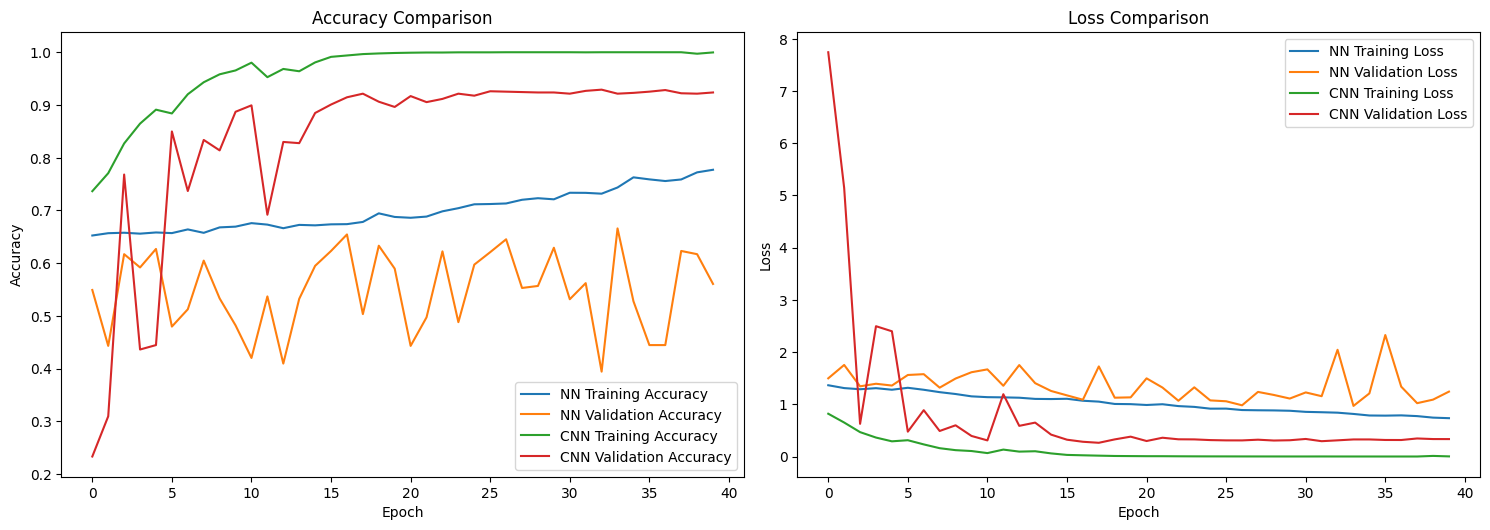


Performance Summary:

Neural Network Model:
Best Training Accuracy: 0.7771
Best Validation Accuracy: 0.6659
Lowest Training Loss: 0.7347
Lowest Validation Loss: 0.9695

Convolutional Neural Network Model:
Best Training Accuracy: 1.0000
Best Validation Accuracy: 0.9291
Lowest Training Loss: 0.0008
Lowest Validation Loss: 0.2634


In [85]:
# plot training histories
plot_training_history(history_nn, history_cnn)

# plot performance summary
performance_summary(history_nn, history_cnn)

Neural Network Performance

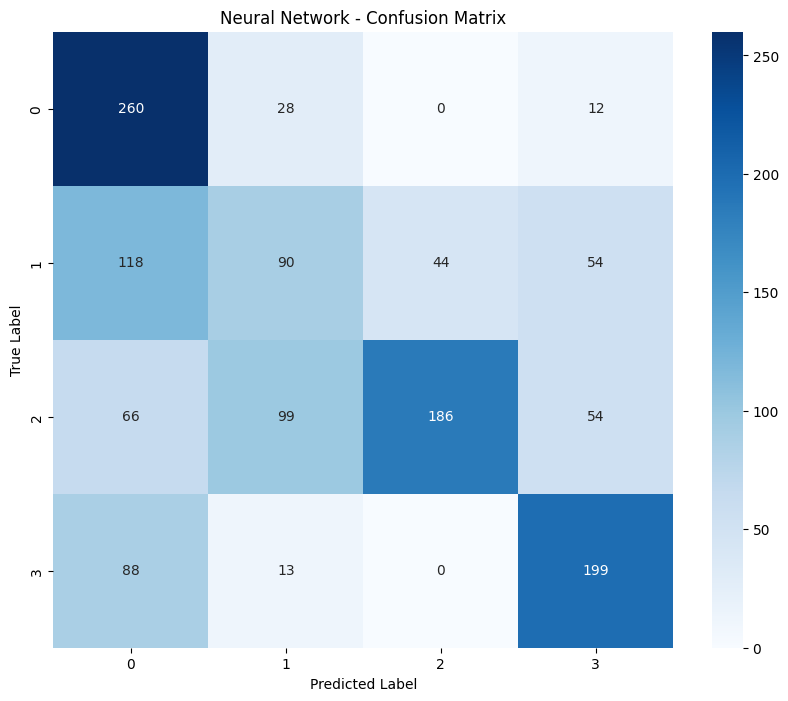


Neural Network - Classification Report:
              precision    recall  f1-score   support

      glioma       0.49      0.87      0.62       300
  meningioma       0.39      0.29      0.34       306
     notumor       0.81      0.46      0.59       405
   pituitary       0.62      0.66      0.64       300

    accuracy                           0.56      1311
   macro avg       0.58      0.57      0.55      1311
weighted avg       0.60      0.56      0.55      1311



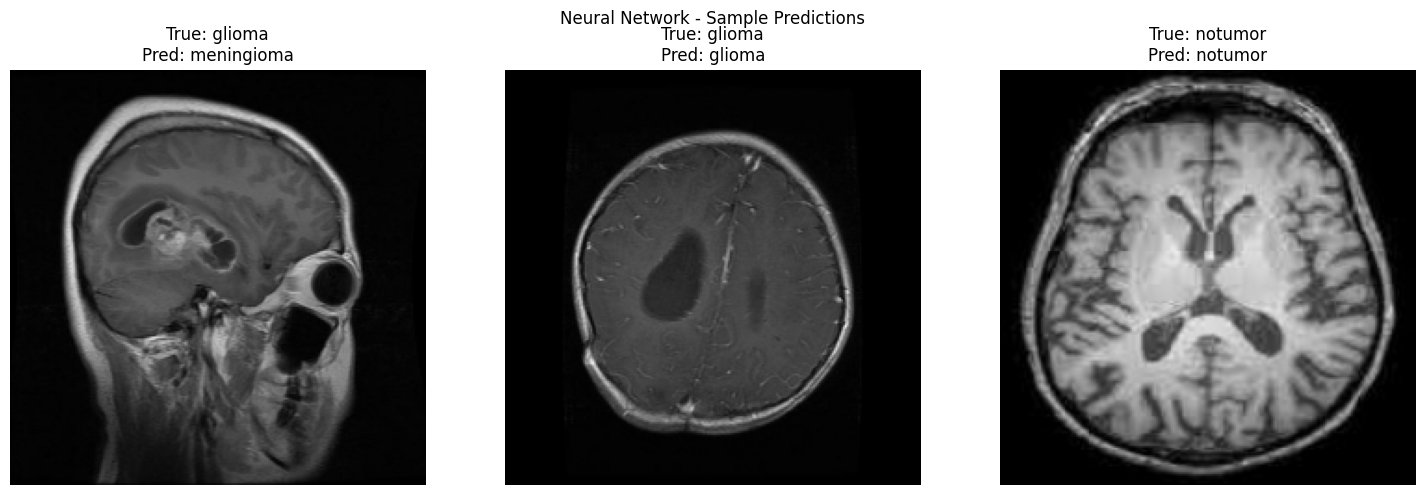

In [86]:
# plot model evaluations
evaluate_model(model1, test_dataset_final, 'Neural Network')

# plot predictions
visualize_predictions(model1, test_dataset_final, 'Neural Network')

Convolutional Neural Network Performance

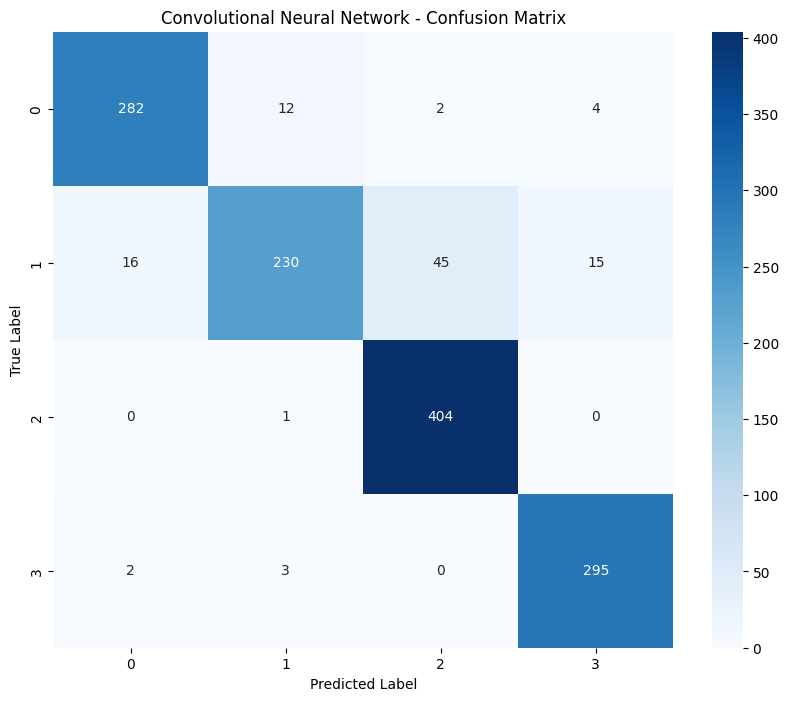


Convolutional Neural Network - Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.94      0.94       300
  meningioma       0.93      0.75      0.83       306
     notumor       0.90      1.00      0.94       405
   pituitary       0.94      0.98      0.96       300

    accuracy                           0.92      1311
   macro avg       0.93      0.92      0.92      1311
weighted avg       0.93      0.92      0.92      1311



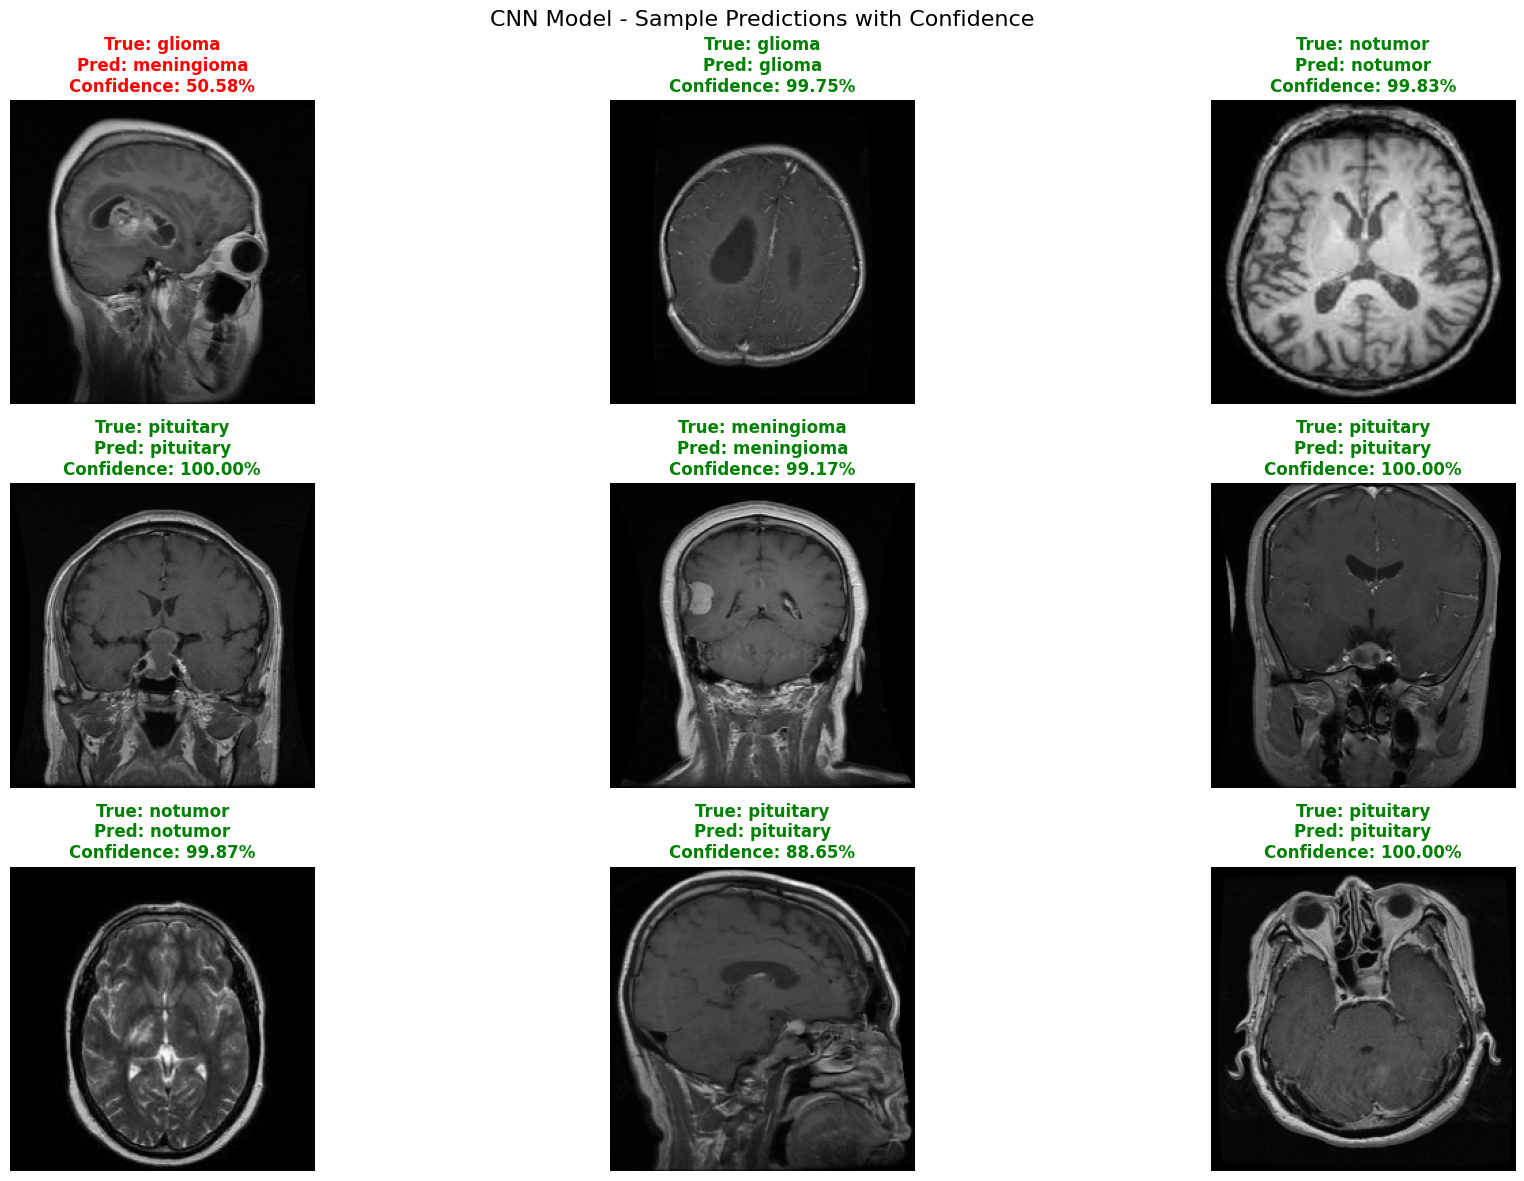

In [87]:
# plot model evaluations
evaluate_model(model2, test_dataset_final, 'Convolutional Neural Network')

# plot predictions
plt.figure(figsize=(20, 12))

for images, labels in test_dataset_final.take(1):
    # get prediction probabilities
    predictions = model2.predict(images, verbose=0)
    
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i+1)
        
        # display image
        plt.imshow(images[i])
        
        # true label
        true_label_idx = np.argmax(labels[i])
        true_label = train_dataset.class_names[true_label_idx]
        
        # predicted label
        pred_label_idx = np.argmax(predictions[i])
        pred_label = train_dataset.class_names[pred_label_idx]
        
        # confidence
        confidence = predictions[i][pred_label_idx] * 100
        
        # colours
        color = 'green' if true_label == pred_label else 'red'
        
        # title
        plt.title(
            f"True: {true_label}\n"
            f"Pred: {pred_label}\n"
            f"Confidence: {confidence:.2f}%", 
            color=color, 
            fontweight='bold'
        )
        
        plt.axis('off')

plt.suptitle('CNN Model - Sample Predictions with Confidence', fontsize=16)
plt.tight_layout()
plt.show()


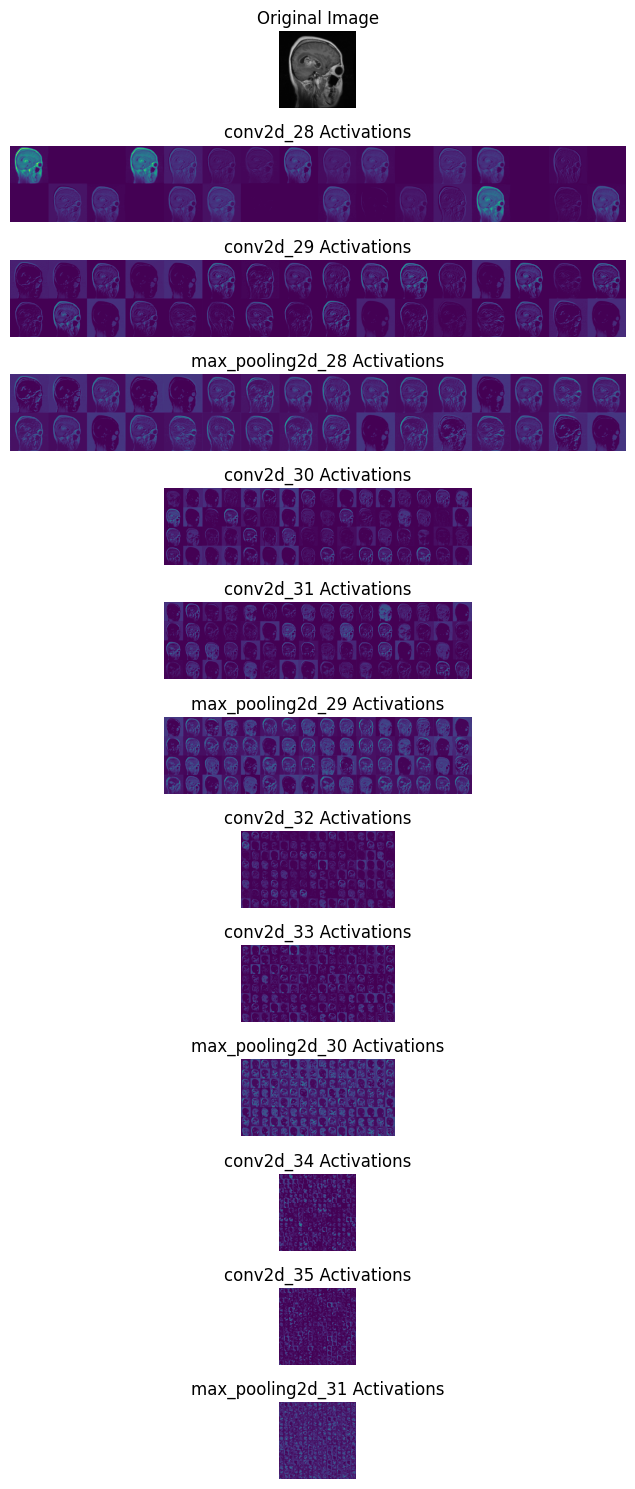

In [88]:
# get image
image_to_visualize, true_label = select_image_for_visualization(test_dataset_final)

# show layers
visualize_layer_activations(model2, image_to_visualize)

To improve the model, heavier regularisation should be implemented or the model should be simplified to address the overfitting. However, 94% accuracy is still a good result and the investigation clearly showed the benefits of CNNs for image processing and image classification tasks.

Heavier Data Augmentation

In [46]:
# a bit smaller
NEW_IMAGE_SIZE = (168, 168)

# image data generator
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.8, 1.2),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")

# train generator
train_generator = train_datagen.flow_from_directory(training_path,
                                                    target_size=NEW_IMAGE_SIZE,
                                                    batch_size=32,
                                                    class_mode="categorical",
                                                    seed=123)

# only rescale for test
test_datagen = ImageDataGenerator(rescale=1./255)

# test generator
test_generator = test_datagen.flow_from_directory(testing_path,
                                                  target_size=NEW_IMAGE_SIZE,
                                                  batch_size=32,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=123)



Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


#### Setting Up For New CNN

- Reduced Image Size
- Same Epochs
- Removed Batch Normalization
- Removed Dropout from Convolutional Layers
- Simplified Convolutional Layer (Less Layers + Less Filters)
- Stronger MaxPooling To Decrease Size of Dense Layer

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_36 (Conv2D)              │ (None, 168, 168, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 915,268 (3.49 MB)

 Trainable params: 915,268 (3.49 MB)

 Non-trainable params: 0 (0.00 B)

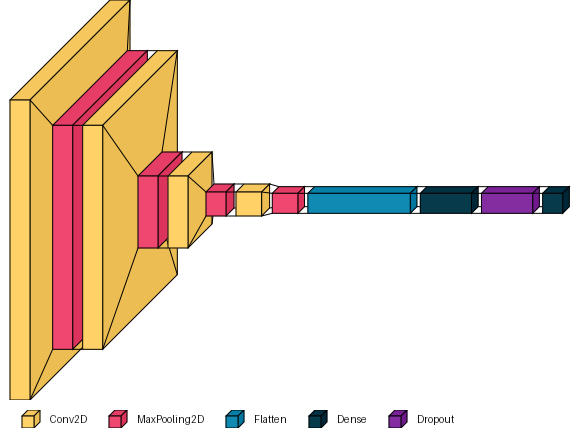

In [47]:
# image shape
NEW_IMAGE_SHAPE = (NEW_IMAGE_SIZE[0], NEW_IMAGE_SIZE[1], 3)

# epochs
epochs = 40

# model 3
model3 = keras.Sequential([
    # first block
    keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=NEW_IMAGE_SHAPE),
    keras.layers.MaxPooling2D((3, 3)),
    
    # second block
    keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((3, 3)),
    
    # third block
    keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((3, 3)),
    
    # fourth block
    keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((3, 3)),
    keras.layers.Flatten(),

    # dense layer
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5, seed=123),
    
    # output layer (dense layer of size 4 with softmax activation)
    keras.layers.Dense(4, activation='softmax') 
])

model3.summary()

# visualise the model
layered_view(model3, legend=True, max_xy=300)


In [48]:
# compile model 3
model3.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
history_cnn_2 = model3.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    verbose=1,
)

Epoch 1/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 192ms/step - accuracy: 0.4486 - loss: 1.1308 - val_accuracy: 0.7590 - val_loss: 0.6289
Epoch 2/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.7673 - loss: 0.5717 - val_accuracy: 0.7689 - val_loss: 0.6231
Epoch 3/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.8094 - loss: 0.4748 - val_accuracy: 0.7918 - val_loss: 0.5188
Epoch 4/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 166ms/step - accuracy: 0.8533 - loss: 0.3617 - val_accuracy: 0.8429 - val_loss: 0.4250
Epoch 5/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step - accuracy: 0.8835 - loss: 0.2989 - val_accuracy: 0.8764 - val_loss: 0.3013
Epoch 6/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.9034 - loss: 0.2446 - val_accuracy: 0.9252 - val_loss: 0.1962
Epoch 7/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step - accuracy: 0.9352 - loss: 0.1859 - val_accuracy: 0.9497 - val_loss: 0.1434
Epoch 8/40
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.9435 - loss: 0

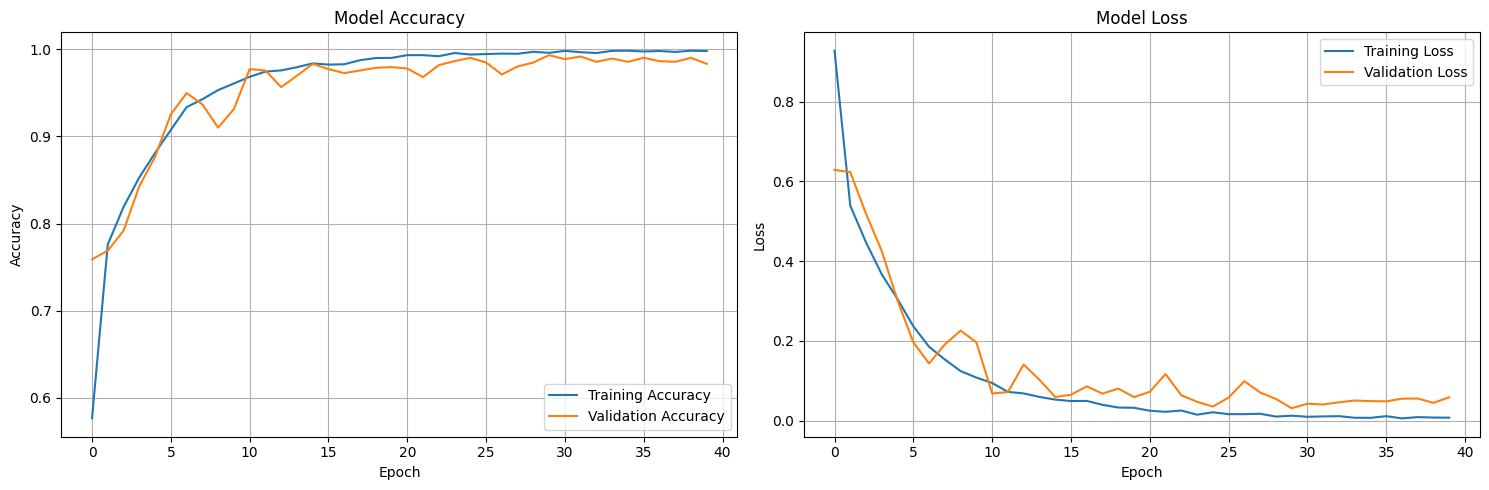

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history_cnn_2.history['accuracy'], label='Training Accuracy')
ax1.plot(history_cnn_2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='lower right')
ax1.grid(True)

# Loss plot
ax2.plot(history_cnn_2.history['loss'], label='Training Loss')
ax2.plot(history_cnn_2.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.tight_layout()
plt.show()

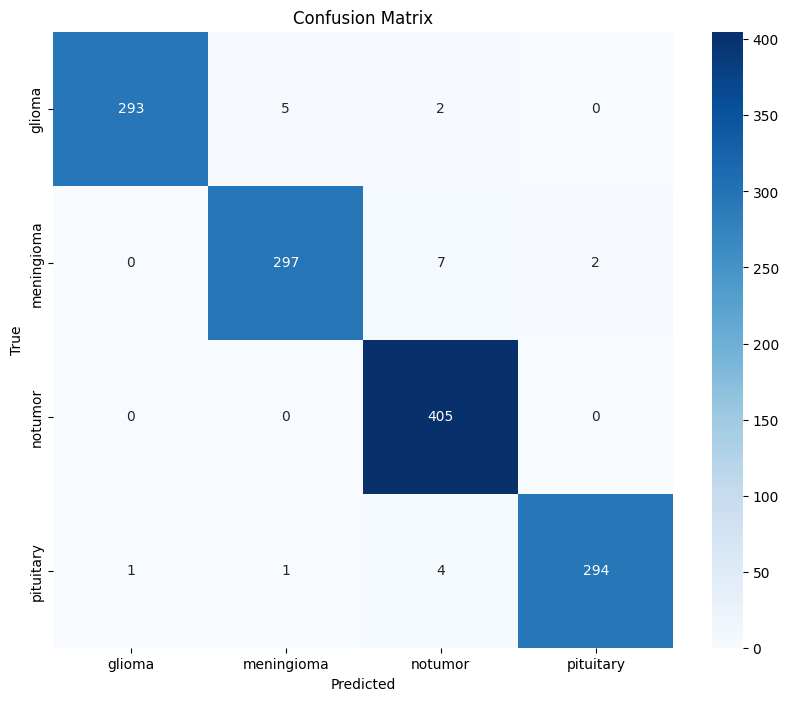


Classification Report:

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.98      0.97      0.98       306
     notumor       0.97      1.00      0.98       405
   pituitary       0.99      0.98      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [90]:
y_true = test_generator.classes

# Get class names
class_names = list(test_generator.class_indices.keys())

# Predict on test data
y_pred_prob = model3.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

In [95]:
print("\nPerformance Summary:")

print("\nConvolutional Neural Network Model 2:")
print(f"Best Training Accuracy: {max(history_cnn_2.history['accuracy']):.4f}")
print(f"Best Validation Accuracy: {max(history_cnn_2.history['val_accuracy']):.4f}")
print(f"Lowest Training Loss: {min(history_cnn_2.history['loss']):.4f}")
print(f"Lowest Validation Loss: {min(history_cnn_2.history['val_loss']):.4f}")


Performance Summary:

Convolutional Neural Network Model 2:
Best Training Accuracy: 0.9982
Best Validation Accuracy: 0.9931
Lowest Training Loss: 0.0057
Lowest Validation Loss: 0.0312


Comparison To Previous Models

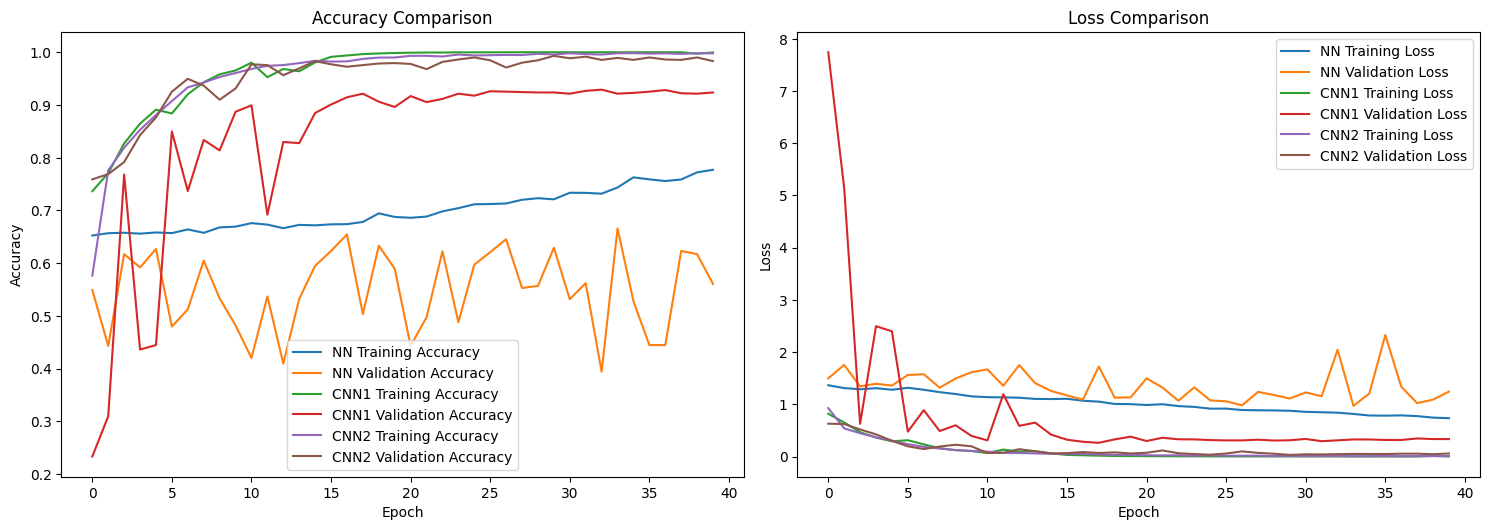

In [92]:
plot_training_history2(history_nn, history_cnn, history_cnn_2)

Sample Predictions

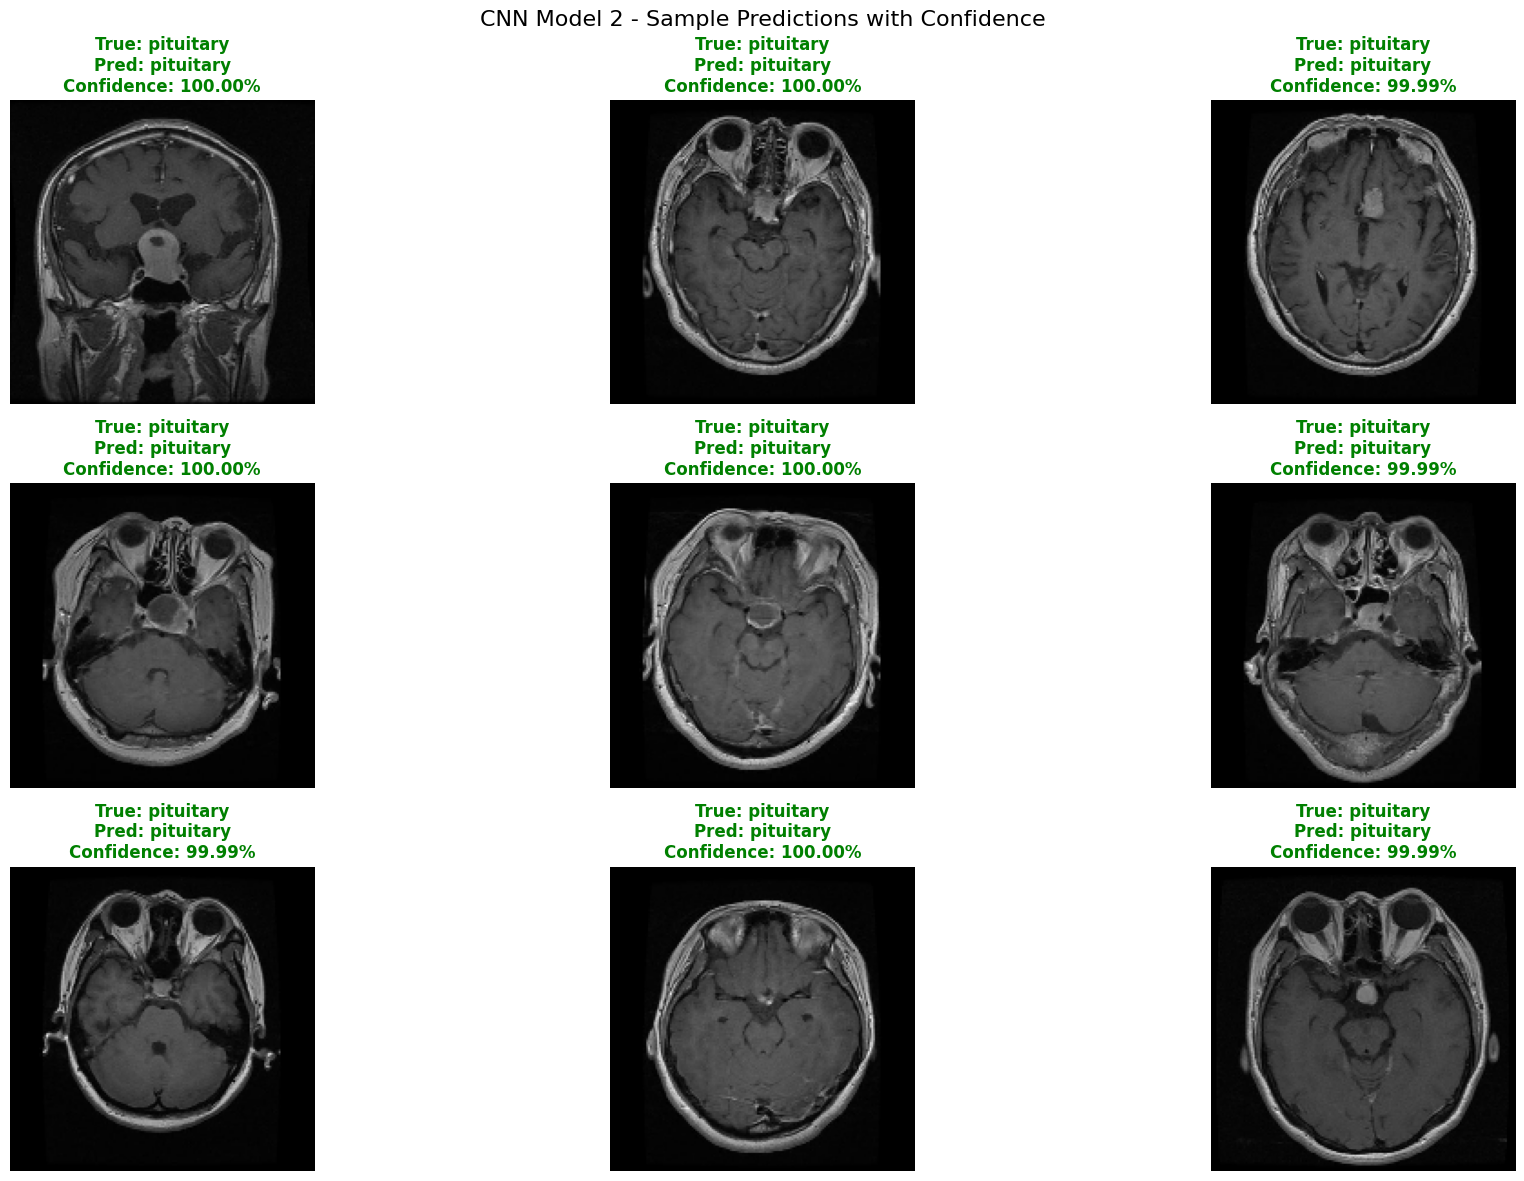

In [93]:
# plot predictions
plt.figure(figsize=(20, 12))

# get batch
images, labels = next(test_generator)

# get probabilities
predictions = model3.predict(images, verbose=0)

for i in range(min(9, len(images))):
    plt.subplot(3, 3, i+1)
    
    plt.imshow(images[i])
    
    true_label_idx = np.argmax(labels[i])
    true_label = list(test_generator.class_indices.keys())[true_label_idx]
    
    pred_label_idx = np.argmax(predictions[i])
    pred_label = list(test_generator.class_indices.keys())[pred_label_idx]
    
    confidence = predictions[i][pred_label_idx] * 100
    
    color = 'green' if true_label == pred_label else 'red'
    
    plt.title(
        f"True: {true_label}\n"
        f"Pred: {pred_label}\n"
        f"Confidence: {confidence:.2f}%", 
        color=color, 
        fontweight='bold'
    )
    
    plt.axis('off')

plt.suptitle('CNN Model 2 - Sample Predictions with Confidence', fontsize=16)
plt.tight_layout()
plt.show()

Activation Filter Examples

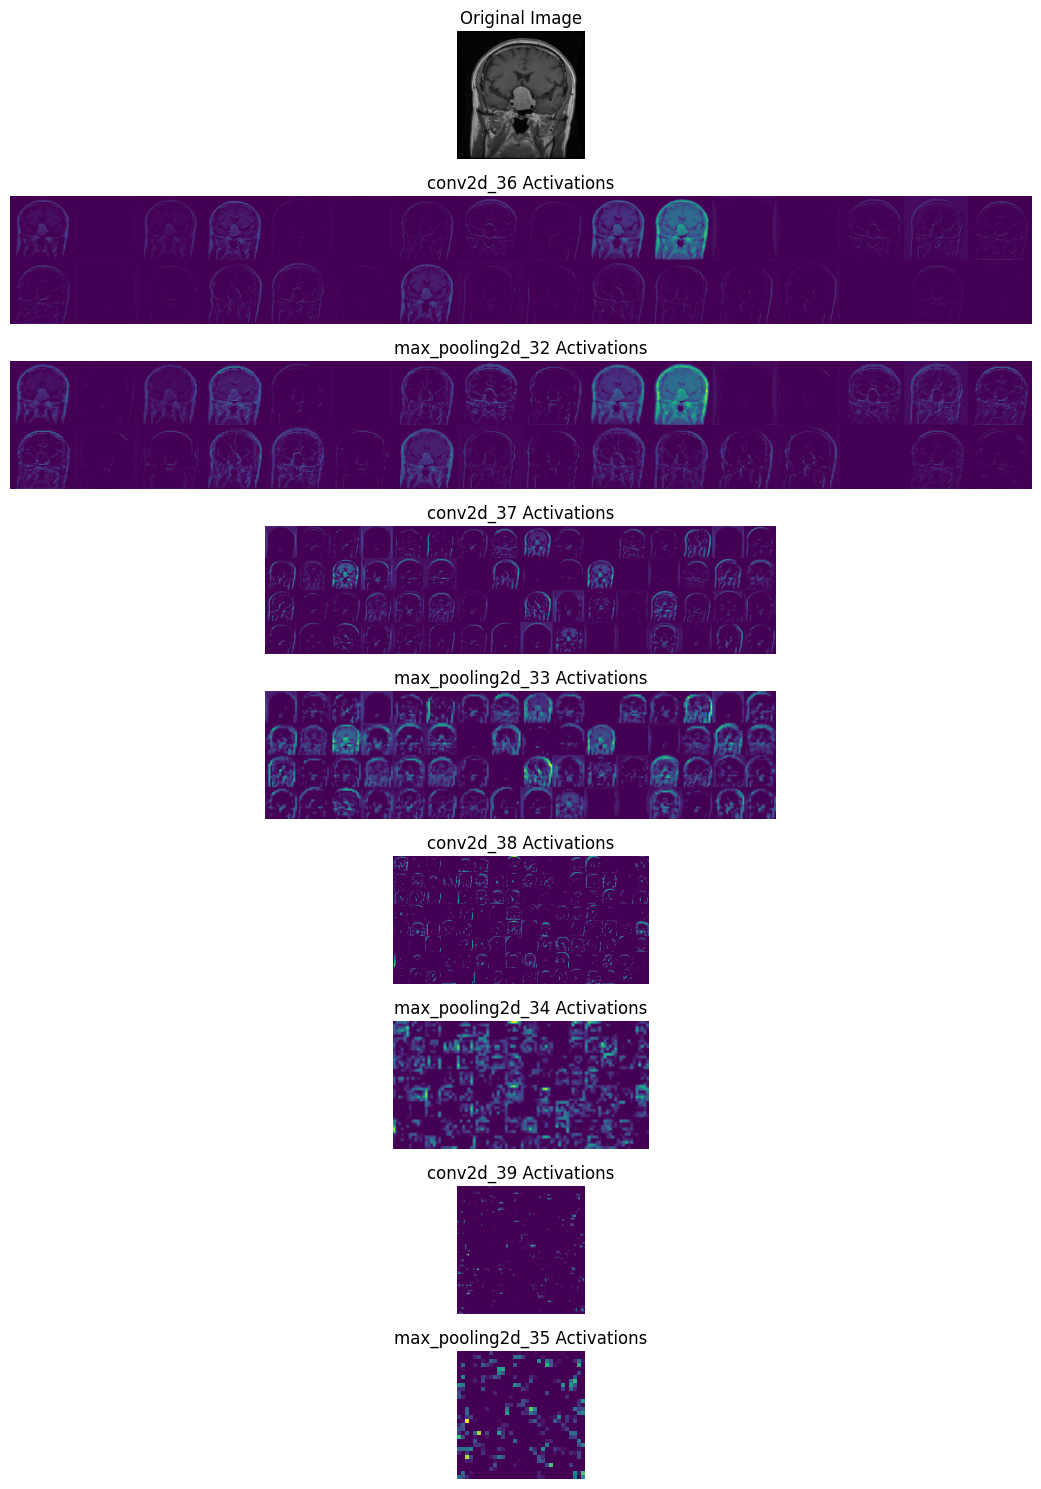

In [94]:
# get image
image_to_visualize, true_label = select_image_for_visualization(test_generator)

# show layers
visualize_layer_activations(model3, image_to_visualize)

The changes made to the convolutional neural network allowed its validation accuracy to increase by preventing overfitting.

##### References

Cheng, J. (2022). Brain Tumor Dataset (Version V1) [Dataset]. Science Data Bank. https://doi.org/10.57760/SCIENCEDB.06290

Bhuvaji, S., Kadam, A., Bhumkar, P., Dedge, S., & Kanchan, S. (2020). Brain Tumor Classification (MRI) [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/1183165

Hamada, A. (2020). Br35H :: Brain Tumor Detection 2020 [Data set]. Kaggle. https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection